In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import nilearn.image, nilearn.masking
from nilearn import plotting as nplt
import statsmodels.stats.multitest
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
today = date.today().strftime("%Y%m%d")

In [4]:
root_dir = '/Volumes/T7SSD1/GL'
script_dir = '.'
fmri_dir = root_dir + '/fMRI_data'
preproc_dir = fmri_dir + '/preproc_data'
data_dir = fmri_dir + '/stats/Reg1_GLM_feedback/group'
roi_dir = root_dir + '/roi'

output_dir = script_dir

In [5]:
temp = glob(join(preproc_dir,'GL*'))
subj_list = [a[-4:] for a in temp]
print(subj_list,'\n',len(subj_list))
# subj_list = ['03','04','05','06','07',
#              '08','09','10','11','12',
#              '14','15','16','17','18',
#              '19','20','21','22','24',
#              '25','26','27','29']

['GL03', 'GL04', 'GL05', 'GL06', 'GL07', 'GL08', 'GL09', 'GL10', 'GL11', 'GL12', 'GL14', 'GL15', 'GL16', 'GL17', 'GL18', 'GL19', 'GL20', 'GL21', 'GL22', 'GL24', 'GL25', 'GL26', 'GL27', 'GL29'] 
 24


In [6]:
roi_list = ('M1','S1')
coord_list = {'M1':(-29,-7,71), 'S1':(-59,-17,55)}
radius = 3

In [7]:
def fast_masking(epi, roi):
    ## Survives only the value in the ROI and reduces the useless dimensions.
    ## input : 5D epi, 3D roi
    ## output : 2D epi
    if epi.shape[:3] != roi.shape:
        raise ValueError('different xyz shape while masking! epi=%s and roi=%s' % (epi.shape[:3],roi.shape))
    fdata_epi = epi.get_fdata()
    fdata_roi = roi.get_fdata().astype(bool)
    
    temp = fdata_epi[fdata_roi,:]
    
    nvolume = temp.shape[0]
    nval = temp.shape[-2]*temp.shape[-1]

    return temp.reshape(nvolume,nval)

In [8]:
def write_data_nifti(data, mask_img, fname):
    if len(mask_img.shape)!=3:
        raise ValueError('mask image should be in 3D format')
    mask_img_asarray = mask_img.get_fdata()
    template = np.zeros_like(mask_img_asarray)
    template[np.where(mask_img_asarray==1)]=data
    img_write = nib.Nifti1Image(template, mask_img.affine)
    img_write.to_filename(fname)

In [9]:
def accuracy(train_X, train_y, test_X, test_y):
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda.fit(train_X, train_y)
    
    return np.mean(lda.predict(test_X) == test_y)

def cross_validation(datasets, target):
    train_y = target + target
    test_y = target
    
    result = []
    
    for i in range(len(datasets)):
        train_X = np.concatenate([a for j, a in enumerate(datasets) if j != i])
        test_X = datasets[i]
        
        result.append(accuracy(train_X, train_y, test_X, test_y))
        
    return np.mean(result)

## Masks

(array([818286,      0,      0, 232338]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]))


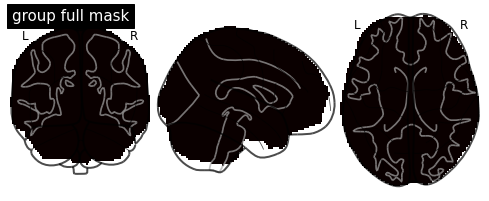

In [10]:
## Full masks of individual subjects (2.000 x 2.000 x 2.000)
path_data = join(roi_dir,'full','full_mask.group.n24.nii.gz')
img_roi = nilearn.image.load_img(path_data)
print(np.histogram(img_roi.get_fdata(), bins=4))
nplt.plot_glass_brain(img_roi, title='group full mask')

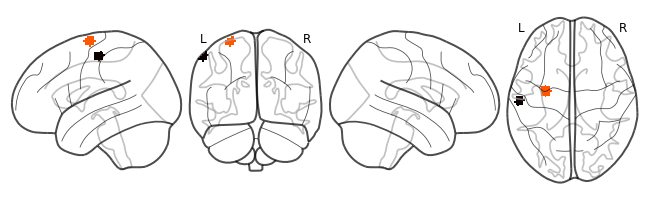

In [11]:
## 3dUndump ROIs from group data
for nn, roi in enumerate(roi_list):
    path_roi = join(roi_dir,'3dUndump.%s.group.rd6.nii.gz'%roi)
    img_roi = nilearn.image.load_img(path_roi)
    if nn == 0:
        img_tot = img_roi
    else:
        img_tot = nilearn.image.math_img('img1+%d*img2'%(nn+1),img1=img_tot,img2=img_roi)
#     nplt.plot_stat_map(img_roi, vmax=1.0, title='%s'%roi, colorbar=False)
nplt.plot_glass_brain(img_tot, display_mode='lyrz')

# GLM results

## FB vs. nFB

In [12]:
# ## epi image (2.000 x 2.000 x 2.000)
# # ============================================================================
# ## extract data of interest
# nn = 1   # sub-brick #1 'SetA-SetB_Tstat'
# path_epi = join(data_dir,'stats.group.n24.nii.gz[%d]'%nn)
# pname = join(data_dir,'temp')
# if not os.path.isfile(pname+'.nii.gz'):
#     os.system("3dcalc -a %s -expr 'a' -prefix %s"%(path_epi,pname))
#     os.system("3dAFNItoNIFTI -prefix %s.nii.gz %s+tlrc"%(pname,pname))
#     os.system("rm %s+tlrc.*"%pname)
# # ============================================================================
# ## load the temporal dataset
# img_epi = nilearn.image.load_img(pname+'.nii.gz')
# print('epi.shape :',img_epi.shape)
# # ============================================================================
# # thsh = 3.7676 # threshold at p = 1.e-3
# thsh = 5.6265 # threshold at p = 1.e-5
# nplt.plot_glass_brain(img_epi, vmax=10.0, plot_abs=False, cmap='RdBu_r', colorbar=True, threshold=thsh, title='GLM: FB-nFB, p = 1.e-5')
# if os.path.isfile(pname+'.nii.gz'):
#     os.system("rm %s.nii.gz"%pname)


epi.shape : (96, 114, 96)


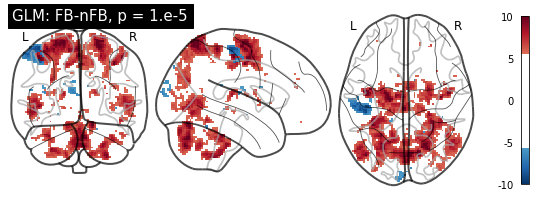

In [13]:
img_bg = join(roi_dir,'mni152_2009bet.nii.gz')
# ============================================================================
## epi image (2.000 x 2.000 x 2.000)
## extract data of interest
nn = 1   # sub-brick #1 'SetA-SetB_Tstat'
path_epi = join(data_dir,'stats.group.n24.nii.gz[%d]'%nn)
pname = join(data_dir,'temp')
if not os.path.isfile(pname+'.nii.gz'):
    os.system("3dAFNItoNIFTI -prefix %s.nii.gz %s"%(pname,path_epi))
# ============================================================================
## load the temporal dataset
img_epi = nilearn.image.load_img(pname+'.nii.gz')
print('epi.shape :',img_epi.shape)
# ============================================================================
# thsh = 3.7676 # threshold at p = 1.e-3
thsh = 5.6265 # threshold at p = 1.e-5
nplt.plot_glass_brain(
    img_epi, threshold=thsh, title='GLM: FB-nFB, p = 1.e-5'
    , vmax=10.0, plot_abs=False, cmap='RdBu_r', colorbar=True
#     , output_file=join(script_dir,today+'.GLM.group.png')
)
if os.path.isfile(pname+'.nii.gz'):
    os.system("rm %s.nii.gz"%pname)

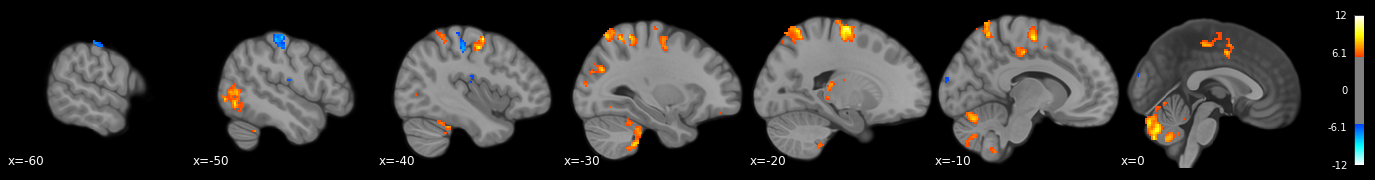

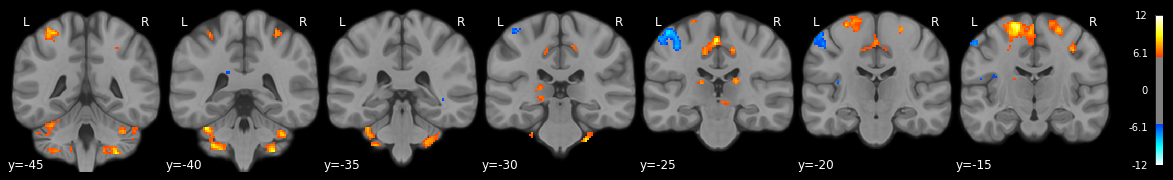

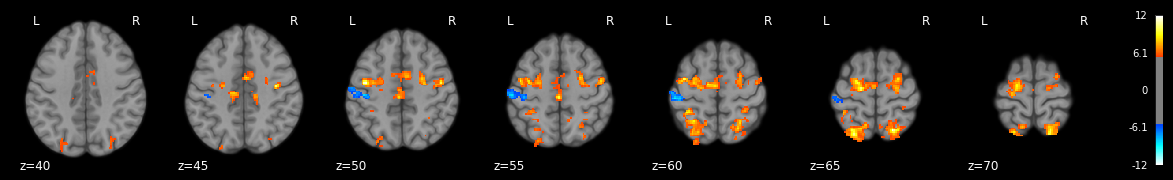

In [14]:
# ============================================================================
## slices
nplt.plot_stat_map(
    img_epi, bg_img=img_bg, threshold=thsh
#     , title='sagittal'
    , display_mode='x', cut_coords=range(-60, 1, 10)
#     , output_file=join(script_dir,today+'.slice_sagittal.group.png')
)
nplt.plot_stat_map(
    img_epi, bg_img=img_bg, threshold=thsh
#     , title='coronal'
    , display_mode='y', cut_coords=range(-45, -14, 5), annotate=True
#     , output_file=join(script_dir,today+'.slice_coronal.group.png')
)
nplt.plot_stat_map(
    img_epi, bg_img=img_bg, threshold=thsh
#     , title='axial'
    , display_mode='z', cut_coords=range(40, 71, 5), annotate=True
#     , output_file=join(script_dir,today+'.slice_axial.group.png')
)

/Users/clmn/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:1595: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/Users/clmn/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:1595: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,
/Users/clmn/.local/lib/python3.8/site-packages/nilearn/plottin

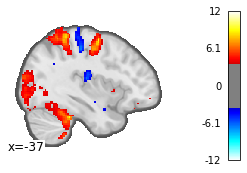

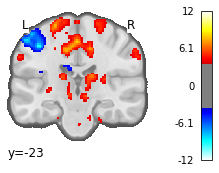

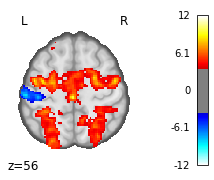

In [23]:
# ============================================================================
thsh = 3.7676 # threshold at p = 1.e-3
## one shot
nplt.plot_stat_map(
    img_epi, bg_img=img_bg, threshold=thsh, black_bg=False
#     , title='sagittal'
    , display_mode='x', cut_coords=[-37]
#     , output_file=join(script_dir,today+'.oneshot_sagittal.group.png')
)
nplt.plot_stat_map(
    img_epi, bg_img=img_bg, threshold=thsh, black_bg=False
#     , title='coronal'
    , display_mode='y', cut_coords=[-23], annotate=True
#     , output_file=join(script_dir,today+'.oneshot_coronal.group.png')
)
nplt.plot_stat_map(
    img_epi, bg_img=img_bg, threshold=thsh, black_bg=False
#     , title='axial'
    , display_mode='z', cut_coords=[56], annotate=True
#     , output_file=join(script_dir,today+'.oneshot_axial.group.png')
)

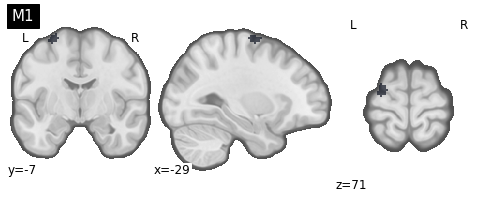

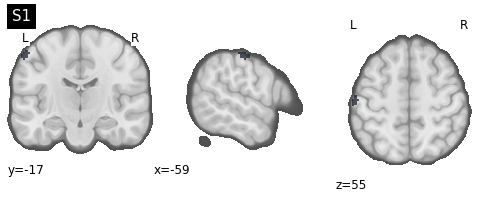

In [19]:
# ============================================================================
## roi cut_coords
cm = LinearSegmentedColormap.from_list('GA', [(1, 1, 1), (19/255, 24/255, 38/255)], N=1)
for roi in roi_list:
    path_roi = join(roi_dir,'3dUndump.%s.group.rd6.nii.gz'%roi)
    img_roi = nilearn.image.load_img(path_roi)
    img_masked = nilearn.image.math_img(img1=img_roi, img2=img_epi, formula='(img1 > 0) * img2')
#     nplt.plot_stat_map(img_masked, title='%s'%roi, colorbar=False, threshold='auto')
    nplt.plot_roi(
        roi_img=img_roi, bg_img=img_bg
        , draw_cross=False, black_bg=False, cmap=cm, title=roi
        , cut_coords=coord_list[roi]
#         , output_file=join(script_dir,today+'.roi_%s.group.png'%roi)
    )

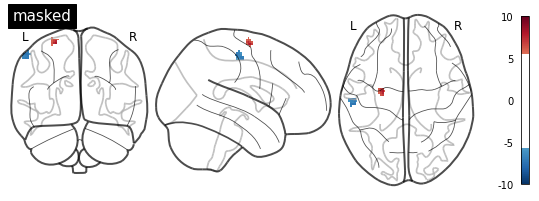

In [16]:
# ============================================================================
thsh = 5.6265 # threshold at p = 1.e-5
## masked epi
img_masked = nilearn.image.math_img(img1=img_tot, img2=img_epi, formula='(img1 > 0) * img2')
nplt.plot_glass_brain(
    img_masked, vmax=10.0, threshold=thsh
    , plot_abs=False, cmap='RdBu_r', colorbar=True, title='masked'
#     , output_file=join(script_dir,today+'.GLM_masked.group.png')
)

In [14]:
# subj = 'GL03'
# roi = 'M1'

# path_roi = join(roi_dir,'3dUndump.%s.group.rd6.nii.gz'%roi)
# img_roi = nilearn.image.load_img(path_roi)

# nn = 1    # At sub-brick #1 'FB#0_Coef' datum type is float: -19.5535 to 20.5078
# path_epi = join(data_dir,'stats.%s.nii.gz'%subj)
# img_epi = nilearn.image.load_img(path_epi)
# temp = fast_masking(epi=img_epi, roi=img_roi)
# np.mean(temp[:,1])

In [14]:
df = pd.DataFrame(columns=['subj','mean','roi','feed'])
for roi in roi_list:
    ## roi
    path_roi = join(roi_dir,'3dUndump.%s.group.rd%d.nii.gz'%(roi,radius))
    img_roi = nilearn.image.load_img(path_roi)
    for subj in subj_list:
        ## epi
        path_epi = join(data_dir,'stats.%s.nii.gz'%subj)
        img_epi = nilearn.image.load_img(path_epi)
        ## masking
        temp = fast_masking(epi=img_epi, roi=img_roi)
        ## feedback
        nn = 1    # At sub-brick #1 'FB#0_Coef' datum type is float: -19.5535 to 20.5078
        mean = np.mean(temp[:,nn])
        df = df.append({'subj':subj,'mean':mean,'roi':roi,'feed':'FB'}, ignore_index=True)
        ## none feedback
        nn = 4    # At sub-brick #4 'nFB#0_Coef' datum type is float: -14.7624 to 17.1531
        mean = np.mean(temp[:,nn])
        df = df.append({'subj':subj,'mean':mean,'roi':roi,'feed':'nFB'}, ignore_index=True)
df

,subj,mean,roi,feed
0,GL03,1.436451,M1,FB
1,GL03,1.009037,M1,nFB
2,GL04,0.379144,M1,FB
3,GL04,0.192779,M1,nFB
4,GL05,1.153934,M1,FB
...,...,...,...,...
91,GL26,4.588650,S1,nFB
92,GL27,0.305043,S1,FB
93,GL27,1.307502,S1,nFB
94,GL29,0.600861,S1,FB


In [ ]:
scipy.stats.ttest_rel()

## t-test

In [15]:
## t : 'True' if a hypothesis is rejected, 'False' if not
## uncorredted_p : pvalues adjusted for multiple hypothesis testing to limit FDR

dt = pd.DataFrame(columns=['roi','rejection','p','uncorrected_p','tval'])

pvals, tvals = [], []

for roi in roi_list:
    sub_df = df[df['roi'] == roi]
    
    FB_mean_accs = sub_df[sub_df['feed'] == 'FB']['mean']
    nFB_mean_accs = sub_df[sub_df['feed'] == 'nFB']['mean']
    
    ## pvalue correction for false discovery rate
    res = scipy.stats.ttest_rel(FB_mean_accs, nFB_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

## rejected(bool), pvalue-corrected(ndarray)
res = statsmodels.stats.multitest.fdrcorrection(pvals=pvals)

for t, p, roi, uncorrected_p, tval in zip(*res, roi_list, pvals, tvals):
    if uncorrected_p < 0.05:
        dt = dt.append(
            {'roi':roi,'rejection':t,'p':p,'uncorrected_p':uncorrected_p,'tval':tval},
            ignore_index=True
        )
dt

,roi,rejection,p,uncorrected_p,tval
0,M1,True,0.000003,0.000003,6.079787
1,S1,True,0.000003,0.000001,-6.449101


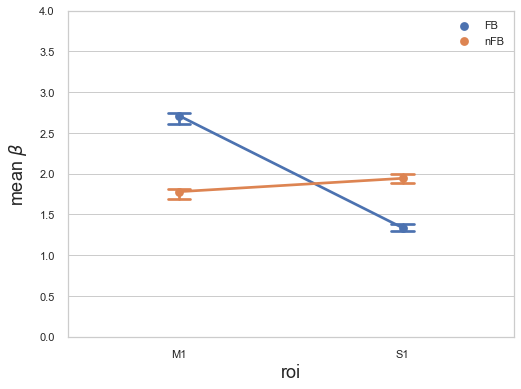

In [40]:
ax = plt.figure(figsize=(8, 6))

plt.style.use('seaborn')

sns.set(style="whitegrid")
sns.pointplot(x='roi', y='mean', data=df,
                   ci=sigma_1*100/np.sqrt(24),      # ci=standard error
                   
                   hue='feed',
                   capsize=.1,
                   markers='o')
plt.ylim(0,4.)
plt.ylabel(r'mean $\beta$', fontsize=18, labelpad=10)
plt.xlabel('roi', size=18)
# plt.title('srad = %d', size=16)   # radius of a roi sphere
plt.legend(loc='best')
# plt.text(1.8, 2.5, 'text', fontsize=20)
# ax.savefig(join(output_dir,today+'.mean_beta.group.srad%d.png'%radius), dpi=300)

# MVPA analysis (GM project)